# Prediction Intervals for data streams

In this part of the tutorial we show how to use prediction interval methods in CapyMOA (MVE and AdaPI), including evaluation and visualization. 

More details about prediction intervals for streaming data can be found in [Adaptive Prediction Interval for Data Stream Regression, PAKDD 2024](https://link.springer.com/chapter/10.1007/978-981-97-2259-4_10)

---

*More information about CapyMOA can be found in* https://github.com/adaptive-machine-learning/CapyMOA

IJCAI 2024 tutorial. Jeju, South Korea (04/08/2024). Heitor Murilo Gomes, Nuwan Gunasekara, Albert Bifet, Bernhard Pfahringer

**Code examples are based on CapyMOA v0.6.0 as of 03/08/2024**

## 1. Prediction interval and evaluation

* An example of the use case of prediction interval in CapyMOA
* The prediction interval methods require a base regression model like SOKNL
* In this first example, we show the evaluation using a **test-then-train loop**, the following example uses `prequential_evaluation()` to avoid write loops over and over again ;)

In [1]:
from capymoa.datasets import Fried
from capymoa.regressor import SOKNL
from capymoa.prediction_interval import MVE, AdaPI
from capymoa.evaluation.evaluation import PredictionIntervalEvaluator, PredictionIntervalWindowedEvaluator

fried_stream = Fried()

# build prediction interval learner in regular manner
soknl = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
mve = MVE(schema=fried_stream.get_schema(), base_learner=soknl)

# build prediction interval learner in in-line manner
mve_inline = MVE(schema=fried_stream.get_schema(), base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10))

# build prediction interval (basic and windowed) evaluators
mve_evaluator = PredictionIntervalEvaluator(schema=fried_stream.get_schema())
mve_windowed_evaluator = PredictionIntervalWindowedEvaluator(schema=fried_stream.get_schema(), window_size=1000)

# run test-then-train/prequential tasks
while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = mve.predict(instance)
    mve_evaluator.update(instance.y_value, prediction)
    mve_windowed_evaluator.update(instance.y_value, prediction)
    mve.train(instance)

# show results
print(f'MVE cumulative evaluation: \n coverage: {mve_evaluator.coverage()}, NMPIW: {mve_evaluator.nmpiw()}')

MVE cumulative evaluation: 
 coverage: 97.28, NMPIW: 30.66


## 1.1 Prediction intervals using `prequential_evaluation()`

* Pretty much like the previous example, but this one uses `prequential_evaluation()`
* Notice how it is the same `prequential_evaluation()` we used for Classification and Regression problems.
* We also plot results over time in this example

MVE coverage: 97.28, NMPIW: 30.66
AdaPI coverage: 96.15, NMPIW: 28.53


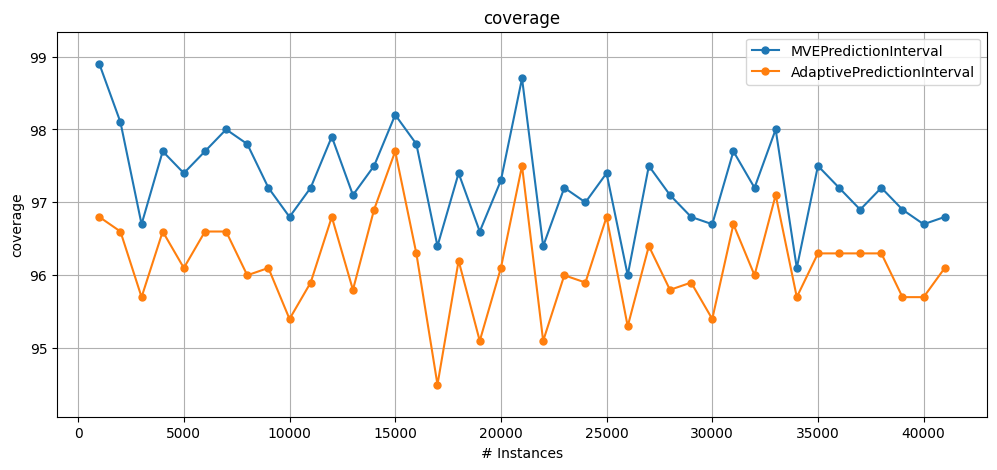

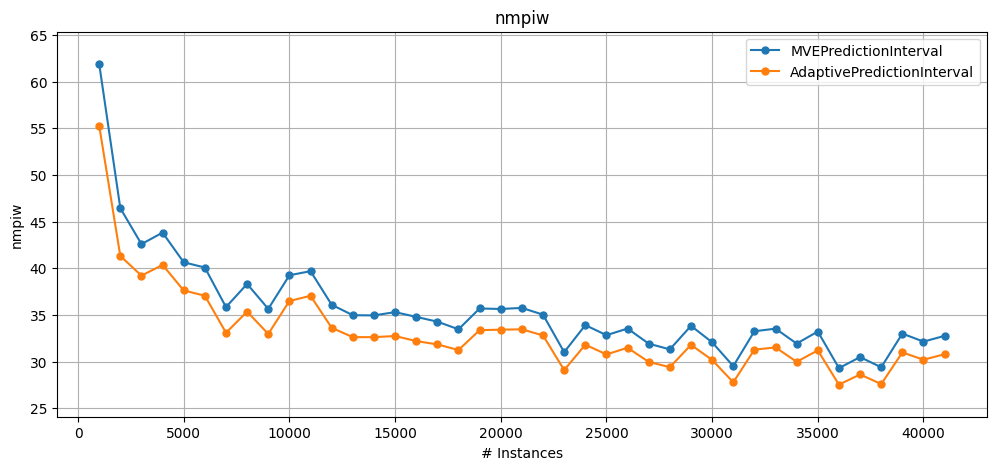

In [2]:
from capymoa.evaluation import prequential_evaluation
from capymoa.prediction_interval import AdaPI
from capymoa.evaluation.visualization import plot_windowed_results

# specify regressive model
regressive_learner = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
# build prediction interval models
mve_learner = MVE(schema=fried_stream.get_schema(), base_learner=regressive_learner)
adapi_learner = AdaPI(schema=fried_stream.get_schema(), base_learner=regressive_learner, limit=0.001)
# gather results
mve_results = prequential_evaluation(stream=fried_stream, learner=mve_learner, window_size=1000)
adapi_results = prequential_evaluation(stream=fried_stream, learner=adapi_learner, window_size=1000)

# show overall results
print(f"MVE coverage: {mve_results.cumulative.coverage()}, NMPIW: {mve_results.cumulative.nmpiw()}")
print(f"AdaPI coverage: {adapi_results.cumulative.coverage()}, NMPIW: {adapi_results.cumulative.nmpiw()}")

# plot results over time
plot_windowed_results(mve_results,adapi_results, metric='coverage')
plot_windowed_results(mve_results,adapi_results, metric='nmpiw')

## 2. Plotting prediction intervals

* We also provide a visualization tool for plotting prediction intervals over time
* The function `plot_prediction_interval` can be used to plot the prediction intervals over time
* The function can take one or two prediction interval results as input

### 2.1 Plotting for 1 algorithm
* To plot the prediction intervals over time, we need to store the predictions and the ground truth values (see `prequential_evaluation()`). This is not scalable for very large streams! But it is fine for analysis purposes.
* The shaded area represents the prediction interval, while the solid line represents the regressive predictions.
* The stared-markers represent the ground truth values that are covered by the intervals.
* The cross-markers represent the ground truth values that are outside the intervals. 
* The colors can be adjusted by the `colors` parameter in the function as a list.
* `start` and `end` parameters can be used to specify the range of the plot.
* The `ground truth` and `predictions` can be omitted by setting the `plot_truth` and `plot_predictions` parameters to `False`.
* In this version, we need to set `optimise` to `Flase` to avoid subscribing problems in `prequential_evaluation()`

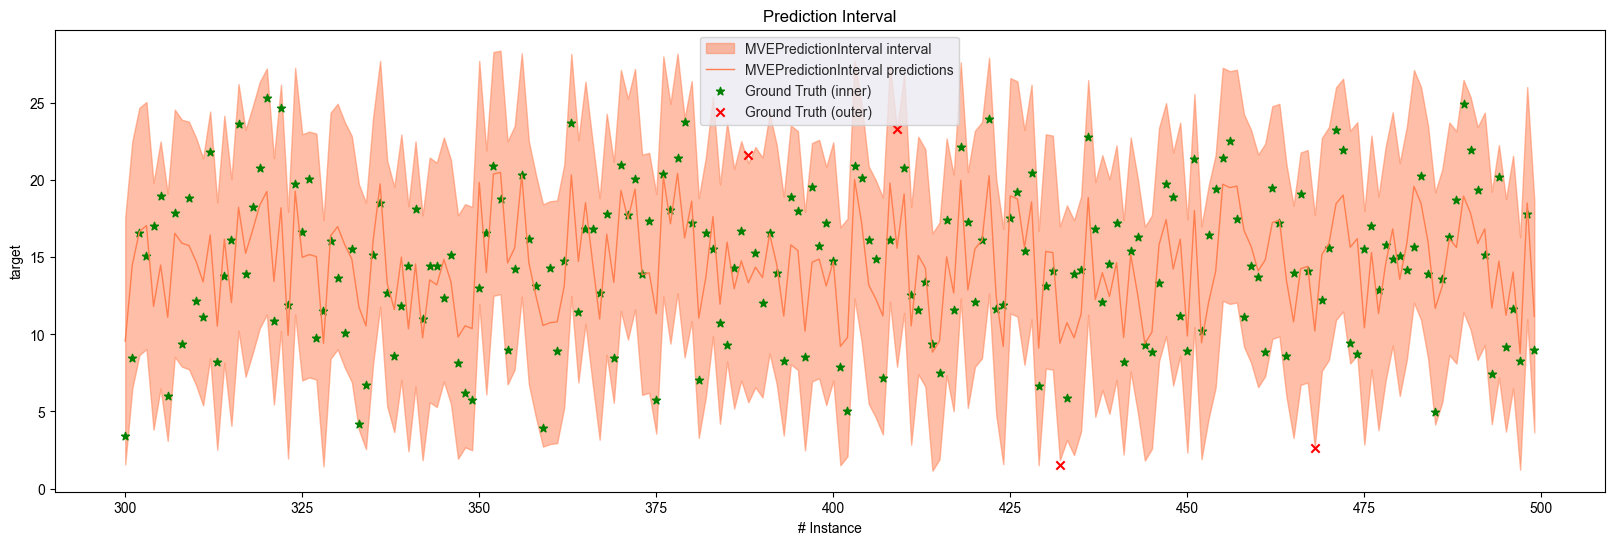

In [3]:
from capymoa.evaluation.visualization import plot_prediction_interval

new_mve_learner = MVE(schema=fried_stream.get_schema(), 
                      base_learner=SOKNL(schema=fried_stream.get_schema(), 
                                         ensemble_size=10)
                     )

new_mve_results = prequential_evaluation(stream=fried_stream, 
                                         learner=new_mve_learner, 
                                         window_size=1000, 
                                         optimise=False, 
                                         store_predictions=True, 
                                         store_y=True)

plot_prediction_interval(new_mve_results, start=300, end=500, colors=['coral'])

### 2.2 Plotting for 2 algorithm

* For comparison purposes, we can also plot two prediction interval results over time.
* We don't take more results since it makes the plot too messy to read.

* \+ "plus" markers represent the ground truth values that are covered by the narrower but not by wider intervals. 
* The function automatically puts the wider area to the back to make the narrower intervals more visible.

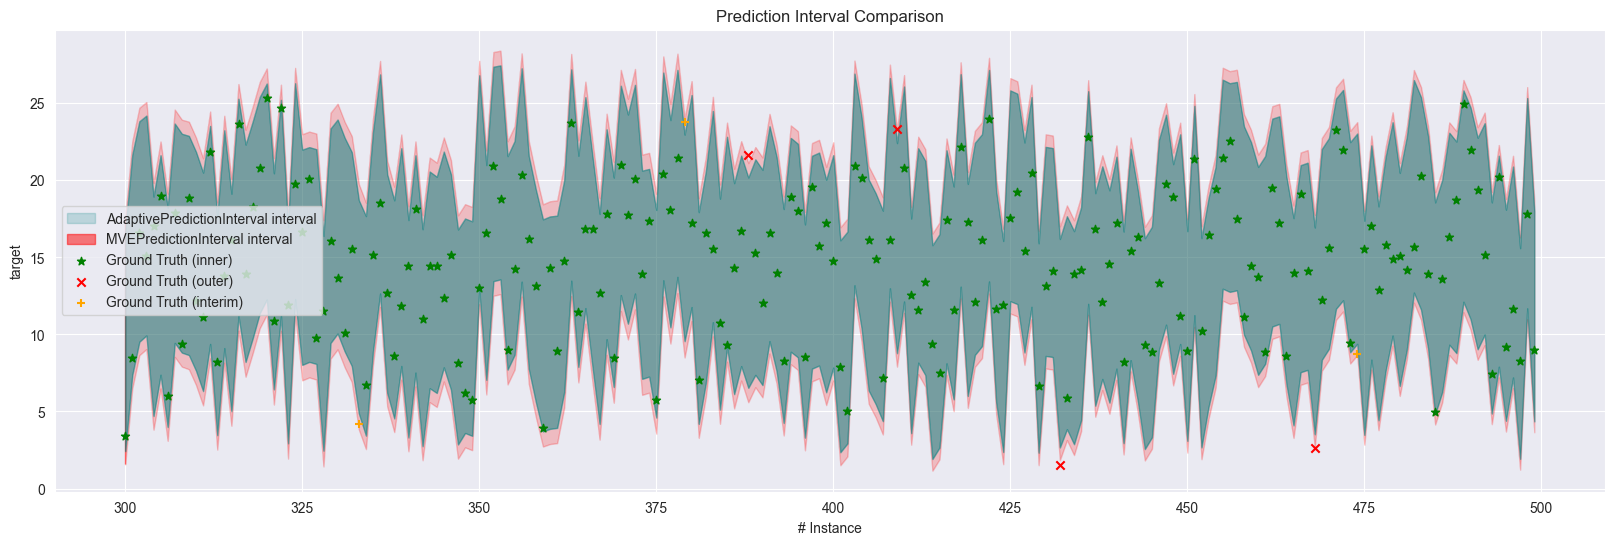

In [4]:
new_adapi_learner = AdaPI(schema=fried_stream.get_schema(), 
                          base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10), limit=0.001)

new_adapi_results = prequential_evaluation(stream=fried_stream, 
                                           learner=new_adapi_learner, 
                                           window_size=1000,
                                           optimise=False,
                                           store_predictions=True, 
                                           store_y=True)

plot_prediction_interval(new_mve_results, new_adapi_results, start=300, end=500,colors=['red','teal'], plot_predictions=False)